In [1]:
from os import chdir
chdir('/home/jovyan')

In [34]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
from lib import postgres as pg
%matplotlib inline

# 1. Electric Power Signals

In [73]:
df0 = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    datetime,
    global_active_power,
    global_reactive_power,
    -- voltage,
    -- current,
    sub_metering_1,
    sub_metering_2,
    sub_metering_3
FROM 
    clean.individual_household_power_consumption_h
) main
ORDER BY 1 ASC
LIMIT 24*365;
""")
df0.head()

,datetime,global_active_power,global_reactive_power,sub_metering_1,sub_metering_2,sub_metering_3
0,2006-12-16 17:00:00,4.223,0.229,0.0,0.032,1.012
1,2006-12-16 18:00:00,3.632,0.080,0.0,0.403,1.012
2,2006-12-16 19:00:00,3.400,0.085,0.0,0.086,1.001
3,2006-12-16 20:00:00,3.269,0.075,0.0,0.000,1.007
4,2006-12-16 21:00:00,3.056,0.077,0.0,0.025,1.033


Text(0, 0.5, 'Global Active Power [kW]')

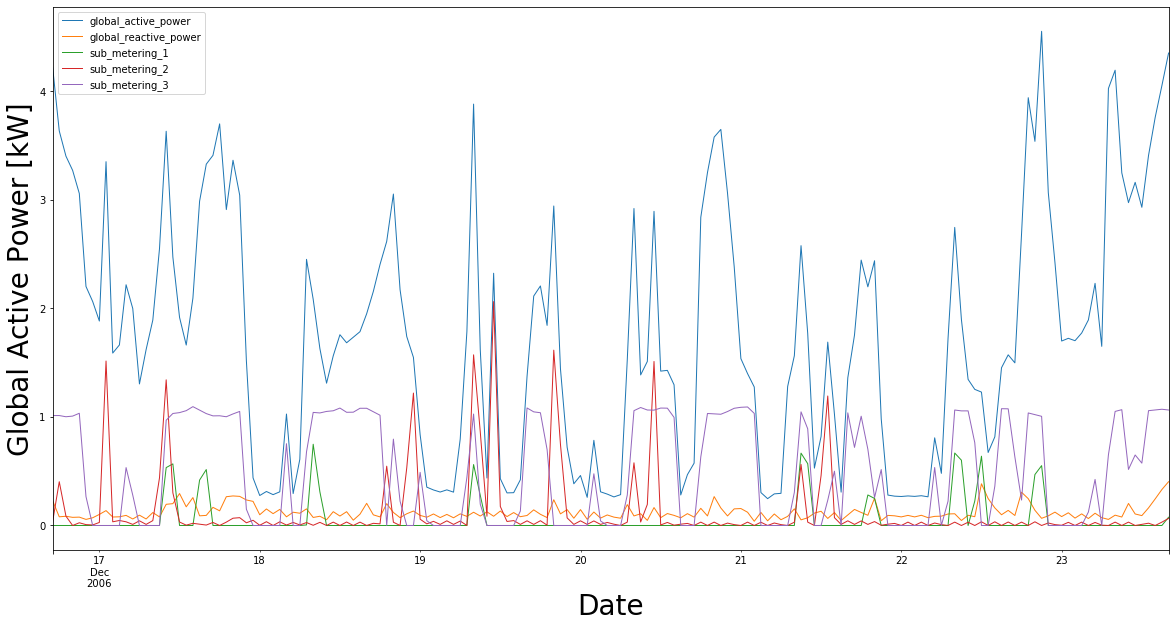

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df1 = df0.set_index('datetime')
df1.plot(ax=ax, lw=1)
ax.set_xlabel('Date',fontsize=28)
ax.set_ylabel('Global Active Power [kW]', fontsize=28)

# 2. Voltage Signal

In [52]:
df2 = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    datetime,
    voltage
FROM
    clean.individual_household_power_consumption_h
) main
ORDER BY 1 ASC
LIMIT 24*7;
""")
df2.head()

,datetime,voltage
0,2006-12-16 17:00:00,234.644
1,2006-12-16 18:00:00,234.580
2,2006-12-16 19:00:00,233.233
3,2006-12-16 20:00:00,234.072
4,2006-12-16 21:00:00,237.159


Text(0, 0.5, 'Voltage [V]')

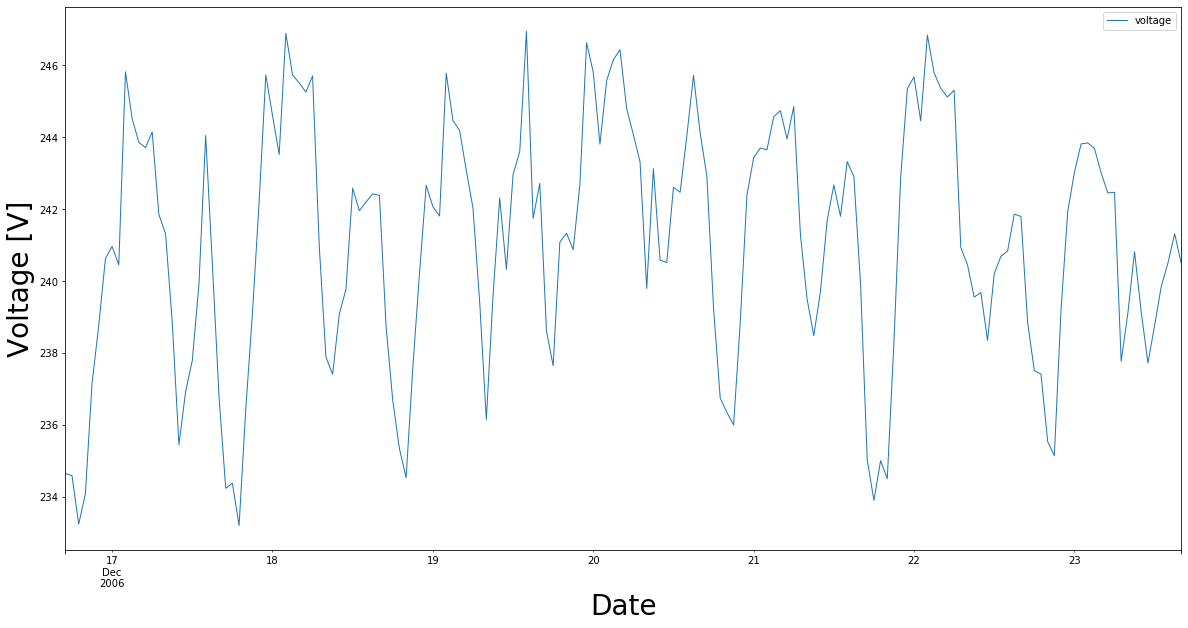

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df3 = df2.set_index('datetime')
df3.plot(ax=ax, lw=1)
ax.set_xlabel('Date',fontsize=28)
ax.set_ylabel('Voltage [V]', fontsize=28)

# 3. Current Signal

In [55]:
df4 = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    datetime,
    current
FROM
    clean.individual_household_power_consumption_h
) main
ORDER BY 1 ASC
LIMIT 24*7;
""")
df4.head()

,datetime,current
0,2006-12-16 17:00:00,18.100
1,2006-12-16 18:00:00,15.600
2,2006-12-16 19:00:00,14.503
3,2006-12-16 20:00:00,13.917
4,2006-12-16 21:00:00,13.047


Text(0, 0.5, 'Current [A]')

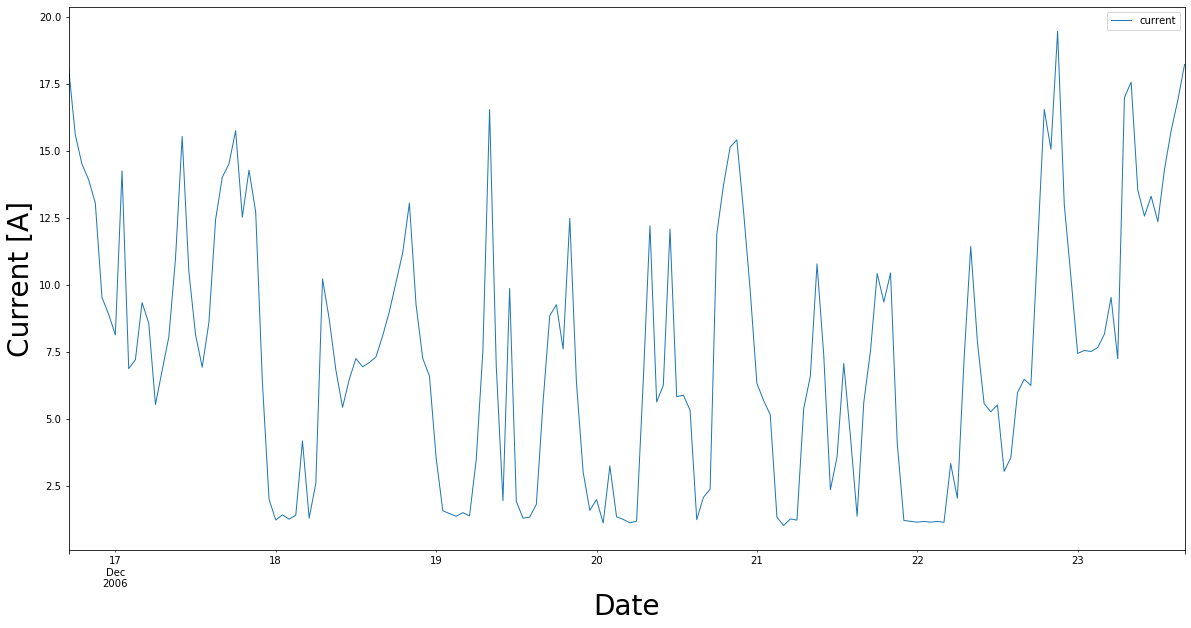

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df5 = df4.set_index('datetime')
df5.plot(ax=ax, lw=1)
ax.set_xlabel('Date',fontsize=28)
ax.set_ylabel('Current [A]', fontsize=28)

# 4. FFT

Text(0, 0.5, 'Global Active Power [kW]')

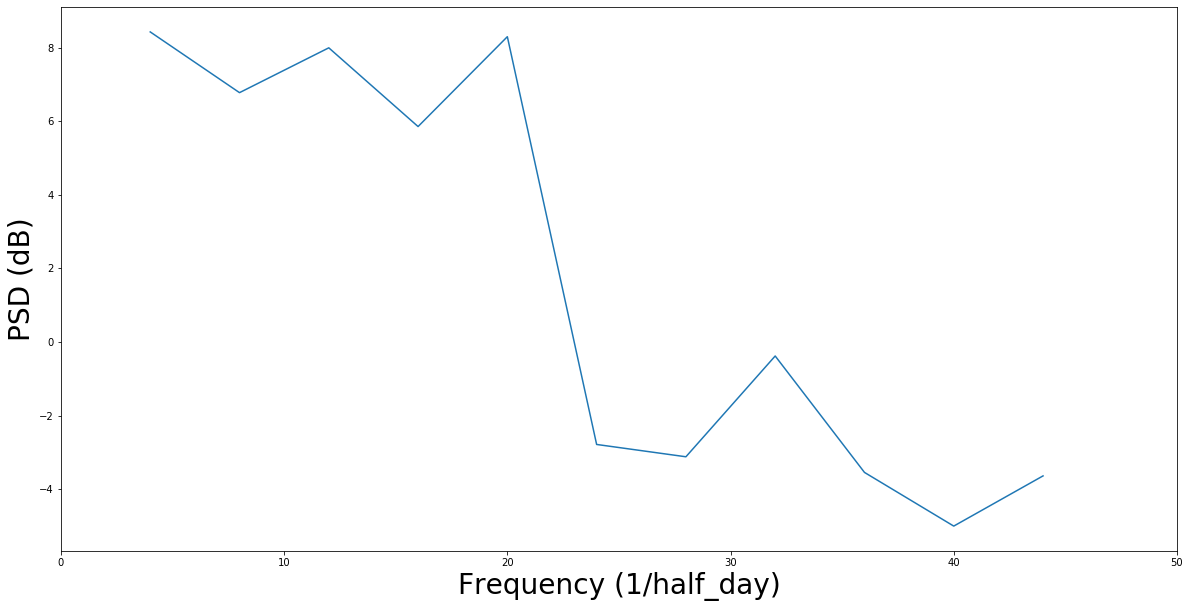

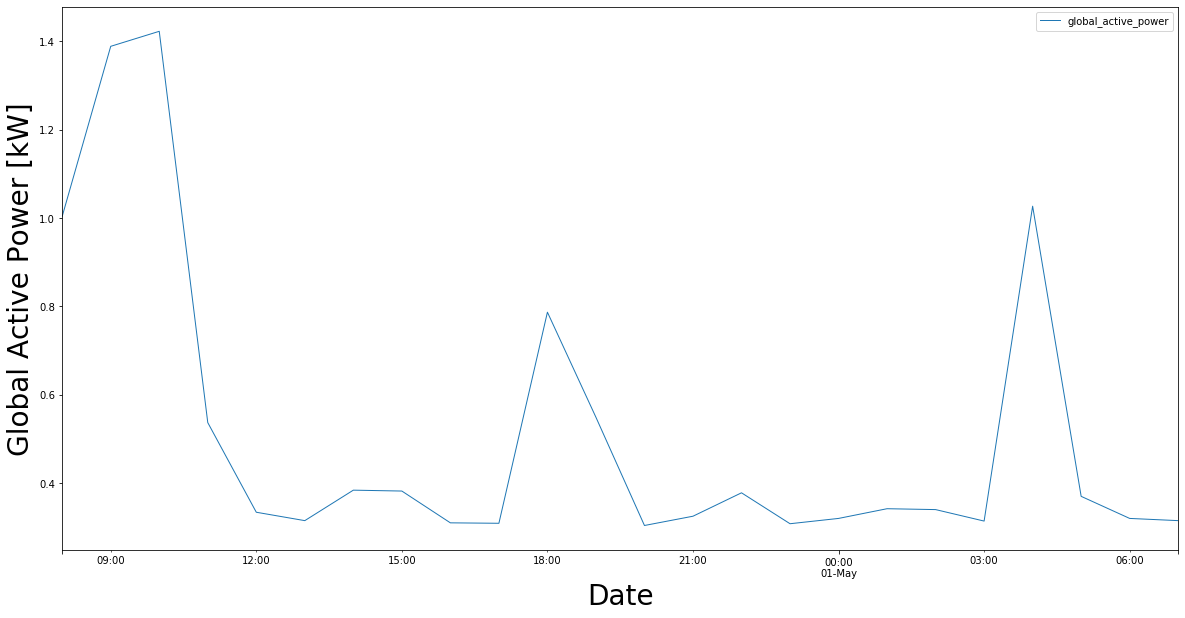

In [66]:
df0 = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    datetime,
    global_active_power
FROM 
    clean.individual_household_power_consumption_h
WHERE
    _id > 12015
) main
ORDER BY 1 ASC
LIMIT 24
;
""")

global_active_power_fft = sp.fftpack.fft(df0['global_active_power'])
global_active_power_psd = np.abs(global_active_power_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(global_active_power_psd), 1/96)
i = fftfreq > 0


fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(fftfreq[i], 10 * np.log10(global_active_power_psd[i]))
ax.set_xlim(0, 50)
ax.set_xlabel('Frequency (1/half_day)', fontsize=28)
ax.set_ylabel('PSD (dB)', fontsize=28)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df1 = df0.set_index('datetime')
df1.plot(ax=ax, lw=1)
ax.set_xlabel('Date',fontsize=28)
ax.set_ylabel('Global Active Power [kW]', fontsize=28)


# 5. FFT Functions

In [8]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
from tqdm import tqdm
from lib import postgres as pg

In [202]:
def serie_fft(serie, frequency, negative_freq):
    
    fft = sp.fftpack.fft(serie)
    psd = np.abs(fft) ** 2
    fft_freq = sp.fftpack.fftfreq(len(psd), frequency)
    
    if negative_freq:
        return fft_freq, 10 * np.log10(psd)
    else:
        i = fft_freq > 0 
        return fft_freq[i], 10 * np.log10(psd[i])

def window_fft(source_schema, source_table, source_column, window_size, frequency, negative_freq = False):
    
    ids_sql = """
        SELECT
            _id
        FROM 
            {}.{}
        WHERE
            _id >= {}
        ORDER BY 1 ASC
        ;
        """.format(source_schema, source_table, window_size)
    ids = pg.load_query_to_df(ids_sql)
    
    features = []
    for _id in tqdm(ids['_id'].values):
        row = {}
        
        serie_sql = """
            SELECT
                {}
            FROM 
                {}.{}
            WHERE
                _id <= {}
            ORDER BY 1 DESC
            LIMIT {}
            ;
            """.format(source_column, source_schema, source_table, _id, window_size)
        df = pg.load_query_to_df(serie_sql)
        
        serie = df[source_column]
        fft_freq, psd_db = serie_fft(serie, frequency, negative_freq)
        
        row['_id'] = _id
        for j in range(1,len(fft_freq)):
            row['f_'+str(fft_freq[j]).replace('.','_')] = psd_db[j]
            
        features.append(row)
    
    return pd.DataFrame(features)
        

In [209]:
features = window_fft('clean', 'individual_household_power_consumption_h', 'global_active_power', 24, 1/12)

100%|██████████| 34566/34566 [04:33<00:00, 126.35it/s]


In [210]:
features.head()

,_id,f_1_0,f_1_5,f_2_0,f_2_5,f_3_0,f_3_5,f_4_0,f_4_5,f_5_0,f_5_5
0,24,13.197138,9.980349,9.383664,6.665131,6.271492,6.157396,5.211782,5.403890,5.562063,4.703601
1,25,11.497763,10.800828,8.850981,6.533895,5.085487,3.845301,4.873607,4.770429,3.941763,5.954233
2,26,10.602523,11.461001,7.905027,6.794484,5.204103,4.685335,4.181879,3.790875,5.737986,1.777256
3,27,10.685980,10.696683,7.778063,6.461112,5.305154,6.081109,4.345389,5.575096,2.891722,3.991165
4,28,10.694250,10.099940,7.757902,4.671029,5.341462,4.152405,5.286377,5.212877,4.967415,3.106884


In [4]:
from lib import transformations as trf

In [5]:
features = trf.window_fft('clean', 'individual_household_power_consumption_h', 'global_active_power', 24, 1/12)

100%|██████████| 34566/34566 [04:50<00:00, 119.07it/s]


# 6. Load dataset to features schema

In [11]:
features.dtypes

_id        int64
f_1_0    float64
f_1_5    float64
f_2_0    float64
f_2_5    float64
f_3_0    float64
f_3_5    float64
f_4_0    float64
f_4_5    float64
f_5_0    float64
f_5_5    float64
dtype: object


CREATE TABLE statement:

`
CREATE TABLE features.IHCPh_fft_w24_f1_12 (
    _id INT PRIMARY KEY,
    f_1_0 float,
    f_1_5 float,
    f_2_0 float,
    f_2_5 float,
    f_3_0 float,
    f_3_5 float,
    f_4_0 float,
    f_4_5 float,
    f_5_0 float,
    f_5_5 float
);`

In [10]:
cmd = """
CREATE TABLE features.IHCPh_fft_w24_f1_12 (
    _id INT PRIMARY KEY,
    f_1_0 float,
    f_1_5 float,
    f_2_0 float,
    f_2_5 float,
    f_3_0 float,
    f_3_5 float,
    f_4_0 float,
    f_4_5 float,
    f_5_0 float,
    f_5_5 float
);
"""
pg.run_command(cmd)

None


In [12]:
pg.bulk_load_df(features, 'features', 'IHCPh_fft_w24_f1_12')

Connecting to Database
Starting DataFrame CSV export...
CSV File has been created
The table features.IHCPh_fft_w24_f1_12 has been successfully truncated.
It wasn't possible to reset serial _id.
The data has been succesfully loaded to table features.IHCPh_fft_w24_f1_12
DB connection closed.
Removing temporary files...
Done.
Elapsed time: 0.9996263980865479 seconds


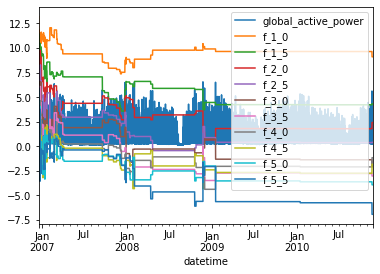

In [31]:
clean = pg.load_query_to_df("""
SELECT
    d.datetime,
    d.global_active_power,
    f.*
FROM
    features.IHCPh_fft_w24_f1_12 f
LEFT JOIN
    clean.individual_household_power_consumption_h d
ON 
    f._id = d._id
ORDER BY f._id ASC
""")
plot = clean.set_index('datetime')
plot = plot.drop(columns=['_id'])
plot.plot()